In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sum
import numpy as np
from statsmodels.tsa.stattools import adfuller


In [126]:
data_df = pd.read_excel(r'dataset_inf.xlsx')
data_df['HICP_l'] = np.log(data_df['HICP'])
data_df['HICPenergy_l'] = np.log(data_df['HICPenergy'])
data_df['output_l'] = np.log(data_df['output'])
#data_df.set_index('Date', inplace=True)

In [127]:
data_df.head()

,Date,HICP,HICPenergy,EURIBOR3,output,HICP_l,HICPenergy_l,output_l
0,2000-01-01,74.86,58.24,3.3431,92.1,4.315620,4.064572,4.522875
1,2000-01-02,75.10,58.89,3.5368,93.2,4.318821,4.075671,4.534748
2,2000-01-03,75.37,60.30,3.7470,93.6,4.322409,4.099332,4.539030
3,2000-01-04,75.45,59.61,3.9253,94.7,4.323470,4.087823,4.550714
4,2000-01-05,75.54,60.36,4.3620,96.0,4.324662,4.100327,4.564348


<AxesSubplot: >

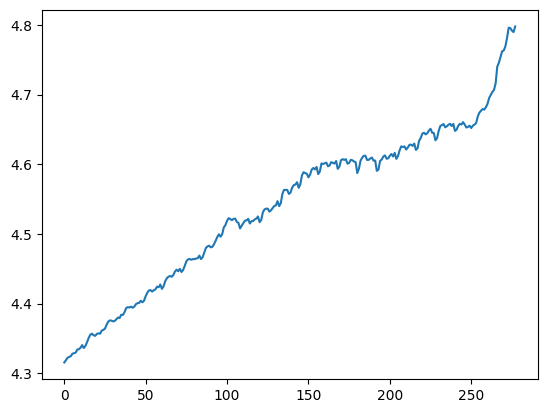

In [128]:
data_df['HICP_l'].plot()

<AxesSubplot: >

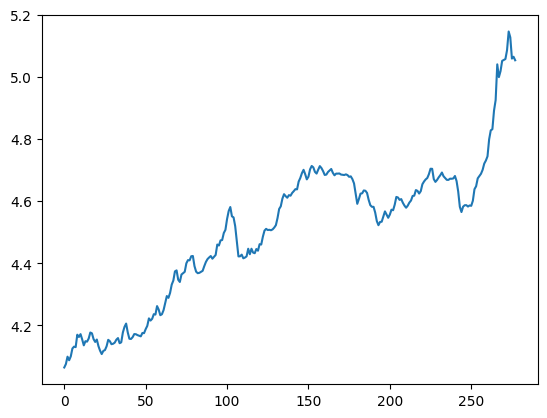

In [129]:
data_df['HICPenergy_l'].plot()

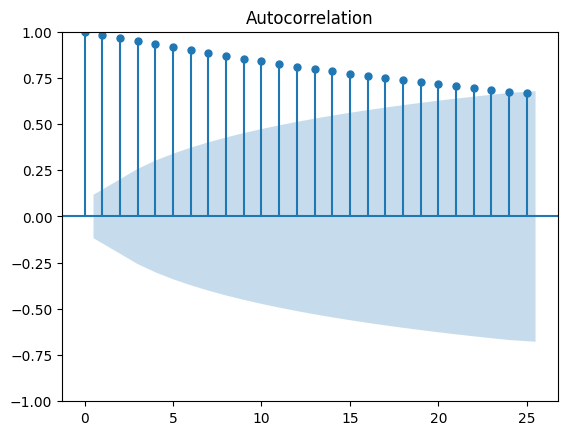

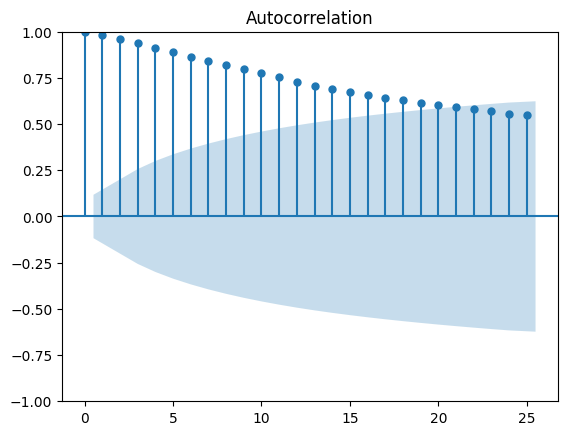

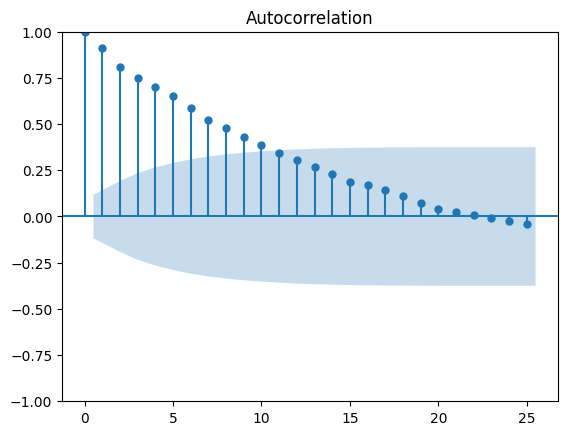

In [130]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_hicp = plot_acf(data_df['HICP_l'])
acf_hicpE = plot_acf(data_df['HICPenergy_l'])
acf_output = plot_acf(data_df['output_l'])


In [131]:
def checkStationarity(series, critical_value, regression):
    test_results = adfuller(series, regression = regression)
    if test_results[1] > critical_value:
        print('Series is Non Stationary')
    else:
        print('Series is Stationary')

    print(f"ADF test statistic: {test_results[0]}")
    print(f"p-value: {test_results[1]}")
    print("Critical thresholds:")   
    for key, value in test_results[4].items():
        print(f"\t{key}: {value}")


In [146]:
data_df['HICP_ld'] = data_df['HICP_l'].diff(1)
data_df.dropna(inplace=True)
checkStationarity(data_df['HICP_ld'], 0.05, 'c')

Series is Non Stationary
ADF test statistic: -2.2928559652081955
p-value: 0.1742824183236102
Critical thresholds:
	1%: -3.457215237265747
	5%: -2.873361841566324
	10%: -2.5730700760129555


In [133]:
data_df['HICHICPenergy_ld'] = data_df['HICPenergy_l'].diff(1)
data_df.dropna(inplace=True)
checkStationarity(data_df['HICHICPenergy_ld'], 0.05, 'ct')

Series is Stationary
ADF test statistic: -12.418848010545913
p-value: 8.624634898047835e-20
Critical thresholds:
	1%: -3.9923195674201506
	5%: -3.426695522751254
	10%: -3.136574826282682


In [134]:
data_df['output_ld'] = data_df['output_l'].diff(1)
data_df.dropna(inplace=True)
checkStationarity(data_df['HICHICPenergy_ld'], 0.05, 'ct')

Series is Stationary
ADF test statistic: -12.461412929256664
p-value: 7.465000500934151e-20
Critical thresholds:
	1%: -3.9924443676593824
	5%: -3.42675556574633
	10%: -3.136610046488589


In [135]:
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order

* $\triangle LHICP = \gamma_0 + \gamma_1 \triangle lHICPE_t + \gamma_2 \triangle lHICPE_{t-1} + \gamma_3 \triangle loutput_t + \gamma_4 \triangle loutput_{t-1} + \gamma_5 \triangle loutput_{t-2} + \gamma_6 lHICP_{t-1} + \epsilon_t$

In [147]:
ardl_1 = ARDL(endog=data_df['HICP_ld'],lags = 1, exog=data_df[['HICHICPenergy_ld', 'output_ld']], order={'HICHICPenergy_ld' : 1,'output_ld' : 2}).fit()

/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [148]:
ardl_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                HICP_ld   No. Observations:                  262
Model:                  ARDL(1, 1, 2)   Log Likelihood                1057.747
Method:               Conditional MLE   S.D. of innovations              0.004
Date:                Wed, 12 Apr 2023   AIC                          -2099.494
Time:                        19:08:13   BIC                          -2070.978
Sample:                             2   HQIC                         -2088.031
                                  262                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0012      0.000      4.346      0.000       0.001       0.002
HICP_ld.L1             -0.0222      0.062     -0.357      0.721      -0.145       0.100
HICHICPenergy_ld.L0     0.1050      0.016      6.698      0.000       0.074       0.136
HICHICPenergy_ld.L1     0.0532      0.017      3.115      0.002       0.020       0.087
output_ld.L0           -0.0313      0.013     -2.463      0.014      -0.056      -0.006
output_ld.L1           -0.0159      0.013     -1.264      0.207      -0.041       0.009
output_ld.L2           -0.0253      0.013     -1.978      0.049      -0.051      -0.000
=======================================================================================
"""

In [149]:
coefficients = ardl_1.params
coefficients

const                  0.001228
HICP_ld.L1            -0.022236
HICHICPenergy_ld.L0    0.105011
HICHICPenergy_ld.L1    0.053244
output_ld.L0          -0.031347
output_ld.L1          -0.015942
output_ld.L2          -0.025309
dtype: float64

In [155]:
ardl_2 = ARDL(endog=data_df['HICP_l'],lags = 2, exog=data_df[['HICPenergy_l', 'output_l']], order={'HICPenergy_l' : 2,'output_l' : 2}).fit()
ardl_3 = ARDL(endog=data_df['HICP_l'],lags = 1, exog=data_df[['HICPenergy_l', 'output_l']], order={'HICPenergy_l' : 1,'output_l' : 2}).fit()

/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [158]:
print(ardl_2.aic)
print(ardl_3.aic)

-2087.181325803408
-2094.7228850879746


In [163]:
result = sum.tsa.stattools.coint(data_df['HICP_l'],data_df['HICPenergy_l'], trend='c', method='aeg')

# print the test results
print('Cointegration test results:')
print('Test statistic:', result[0])
print('p-value:', result[1])
print('Critical values:', result[2])

if result[1] < 0.05: 
    print('Cointegration')
else:
    print('No Cointegration')

Cointegration test results:
Test statistic: -2.3805153834091035
p-value: 0.33413802487037436
Critical values: [-3.93889347 -3.3596405  -3.06073974]
No Cointegration


In [ ]:
ar = sum.tsa.AutoReg(data_df['HICP_l'], lags = 3).fit( )